<a href="https://colab.research.google.com/github/edsonportosilva/OptiCommPy/blob/main/examples/test_WDM_transmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulation of coherent WDM transmission

In [1]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install . 

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from optic.dsp import pulseShape, firFilter, decimate, symbolSync, pnorm
from optic.models import phaseNoise, pdmCoherentReceiver

try:
    from optic.modelsGPU import manakovSSF
except:
    from optic.models import manakovSSF

from optic.tx import simpleWDMTx
from optic.core import parameters
from optic.equalization import edc, mimoAdaptEqualizer
from optic.carrierRecovery import cpr
from optic.metrics import fastBERcalc, monteCarloGMI, monteCarloMI, signal_power, calcEVM
from optic.plot import pconst

import scipy.constants as const

import logging as logg
logg.getLogger().setLevel(logg.INFO)
logg.basicConfig(format='%(message)s')

In [3]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [4]:
figsize(10, 3)

In [5]:
# %load_ext autoreload
# %autoreload 2
#%load_ext line_profiler


## Transmitter

**Polarization multiplexed WDM signal generation**

In [6]:
# Transmitter parameters:
paramTx = parameters()
paramTx.M   = 16           # order of the modulation format
paramTx.Rs  = 32e9         # symbol rate [baud]
paramTx.SpS = 16           # samples per symbol
paramTx.pulse = 'rrc'      # pulse shaping filter
paramTx.Ntaps = 1024       # number of pulse shaping filter coefficients
paramTx.alphaRRC = 0.01    # RRC rolloff
paramTx.Pch_dBm = 0        # power per WDM channel [dBm]
paramTx.Nch     = 11       # number of WDM channels
paramTx.Fc      = 193.1e12 # central optical frequency of the WDM spectrum
paramTx.freqSpac = 37.5e9  # WDM grid spacing
paramTx.Nmodes = 2         # number of signal modes [2 for polarization multiplexed signals]
paramTx.Nbits = int(np.log2(paramTx.M)*1e5) # total number of bits per polarization

# generate WDM signal
sigWDM_Tx, symbTx_, paramTx = simpleWDMTx(paramTx)

  0%|          | 0/11 [00:00<?, ?it/s]

channel 0	 fc : 192.9125 THz
  mode #0	 power: -3.01 dBm
  mode #1	 power: -3.01 dBm
channel 0	 power: 0.00 dBm

channel 1	 fc : 192.9500 THz
  mode #0	 power: -3.01 dBm
  mode #1	 power: -3.01 dBm
channel 1	 power: 0.00 dBm

channel 2	 fc : 192.9875 THz
  mode #0	 power: -3.01 dBm
  mode #1	 power: -3.01 dBm
channel 2	 power: -0.00 dBm

channel 3	 fc : 193.0250 THz
  mode #0	 power: -3.01 dBm
  mode #1	 power: -3.01 dBm
channel 3	 power: -0.00 dBm

channel 4	 fc : 193.0625 THz
  mode #0	 power: -3.01 dBm
  mode #1	 power: -3.01 dBm
channel 4	 power: 0.00 dBm

channel 5	 fc : 193.1000 THz
  mode #0	 power: -3.01 dBm
  mode #1	 power: -3.01 dBm
channel 5	 power: 0.00 dBm

channel 6	 fc : 193.1375 THz
  mode #0	 power: -3.01 dBm
  mode #1	 power: -3.01 dBm
channel 6	 power: 0.00 dBm

channel 7	 fc : 193.1750 THz
  mode #0	 power: -3.01 dBm
  mode #1	 power: -3.01 dBm
channel 7	 power: -0.00 dBm

channel 8	 fc : 193.2125 THz
  mode #0	 power: -3.01 dBm
  mode #1	 power: -3.01 dBm
channel 

**Nonlinear fiber propagation with the split-step Fourier method**

In [7]:
# optical channel parameters
paramCh = parameters()
paramCh.Ltotal = 700     # total link distance [km]
paramCh.Lspan  = 50      # span length [km]
paramCh.alpha = 0.2      # fiber loss parameter [dB/km]
paramCh.D = 16           # fiber dispersion parameter [ps/nm/km]
paramCh.gamma = 1.3      # fiber nonlinear parameter [1/(W.km)]
paramCh.Fc = paramTx.Fc  # central optical frequency of the WDM spectrum
paramCh.hz = 1           # step-size of the split-step Fourier method [km]
paramCh.maxIter = 5      # maximum number of convergence iterations per step
paramCh.tol = 1e-5       # error tolerance per step
paramCh.prgsBar = True   # show progress bar?

Fs = paramTx.Rs*paramTx.SpS # sampling rate

# nonlinear signal propagation
sigWDM, paramCh = manakovSSF(sigWDM_Tx, Fs, paramCh)

  0%|          | 0/14 [00:00<?, ?it/s]

**Optical WDM spectrum before and after transmission**

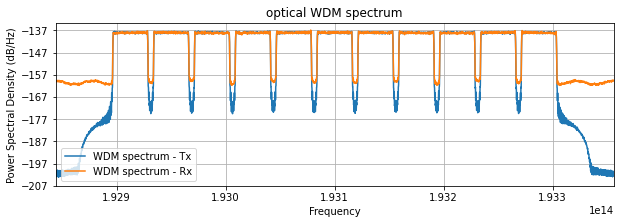

In [8]:
# plot psd
plt.figure(figsize=(10, 3))
plt.xlim(paramCh.Fc-Fs/2,paramCh.Fc+Fs/2);
plt.psd(sigWDM_Tx[:,0], Fs=Fs, Fc=paramCh.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Tx')
plt.psd(sigWDM[:,0], Fs=Fs, Fc=paramCh.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Rx')
plt.legend(loc='lower left')
plt.title('optical WDM spectrum');

### WDM channels coherent detection and demodulation

Demodulating channel #5 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 10.00 dBm, lw: 200.00 kHz, FO: 150.00 MHz



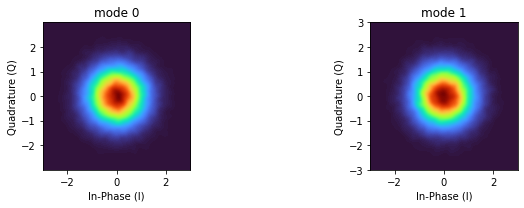

In [9]:
# Receiver

# parameters
chIndex  = 5     # index of the channel to be demodulated

Fc = paramCh.Fc
Ts = 1/Fs
freqGrid = paramTx.freqGrid

print('Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n'\
      %(chIndex, (Fc + freqGrid[chIndex])/1e12, const.c/(Fc + freqGrid[chIndex])/1e-9))

symbTx = symbTx_[:,:,chIndex]

# local oscillator (LO) parameters:
FO      = 150e6                # frequency offset
Δf_lo   = freqGrid[chIndex]+FO  # downshift of the channel to be demodulated
lw      = 200e3                 # linewidth
Plo_dBm = 10                    # power in dBm
Plo     = 10**(Plo_dBm/10)*1e-3 # power in W
ϕ_lo    = 0                     # initial phase in rad    

print('Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz\n'\
      %(Plo_dBm, lw/1e3, FO/1e6))

# generate LO field
π       = np.pi
t       = np.arange(0, len(sigWDM))*Ts
ϕ_pn_lo = phaseNoise(lw, len(sigWDM), Ts)
sigLO   = np.sqrt(Plo)*np.exp(1j*(2*π*Δf_lo*t + ϕ_lo + ϕ_pn_lo))

# polarization multiplexed coherent optical receiver

# photodiodes parameters
paramPD = parameters()
paramPD.B = paramTx.Rs
paramPD.Fs = Fs    
paramPD.ideal = True

θsig = π/3 # polarization rotation angle
sigRx = pdmCoherentReceiver(sigWDM, sigLO, θsig, paramPD)

# plot received constellations
pconst(sigRx[0::paramTx.SpS,:], R=3);

### Matched filtering and CD compensation

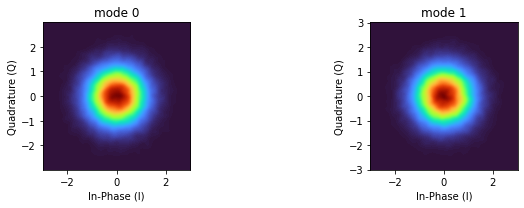

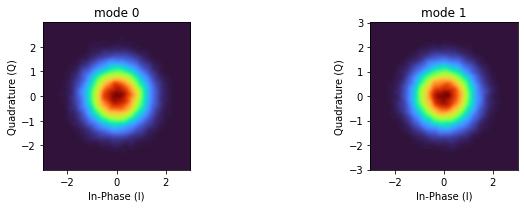

(<Figure size 720x216 with 2 Axes>,
 <AxesSubplot:title={'center':'mode 1'}, xlabel='In-Phase (I)', ylabel='Quadrature (Q)'>)

In [10]:
# Rx filtering

# Matched filtering
if paramTx.pulse == 'nrz':
    pulse = pulseShape('nrz', paramTx.SpS)
elif paramTx.pulse == 'rrc':
    pulse = pulseShape('rrc', paramTx.SpS, N=paramTx.Ntaps, alpha=paramTx.alphaRRC, Ts=1/paramTx.Rs)
    
pulse = pulse/np.max(np.abs(pulse))            
sigRx = firFilter(pulse, sigRx)

# plot constellations after matched filtering
pconst(sigRx[0::paramTx.SpS,:], R=3)

# CD compensation
sigRx = edc(sigRx, paramCh.Ltotal, paramCh.D, Fc-Δf_lo, Fs)

# plot constellations after CD compensation
pconst(sigRx[0::paramTx.SpS,:], R=3)

### Downsampling to 2 samples/symbol and re-synchronization with transmitted sequences

In [11]:
# decimation
paramDec = parameters()
paramDec.SpS_in  = paramTx.SpS
paramDec.SpS_out = 2
sigRx = decimate(sigRx, paramDec)

symbRx = symbolSync(sigRx, symbTx, 2)

### Power normalization

In [12]:
x = pnorm(sigRx)
d = pnorm(symbRx)

### Adaptive equalization

da-rde - training stage #0
da-rde pre-convergence training iteration #0
da-rde MSE = 0.032630.
da-rde pre-convergence training iteration #1
da-rde MSE = 0.030582.
da-rde pre-convergence training iteration #2
da-rde MSE = 0.030509.
da-rde pre-convergence training iteration #3
da-rde MSE = 0.030457.
da-rde pre-convergence training iteration #4
da-rde MSE = 0.030421.
rde - training stage #1
rde MSE = 0.023067.


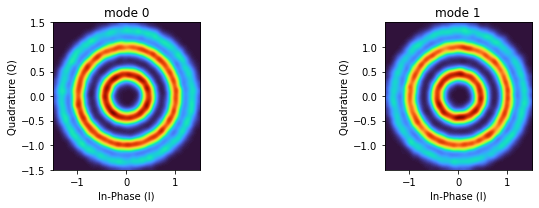

In [13]:
# adaptive equalization parameters
paramEq = parameters()
paramEq.nTaps = 15
paramEq.SpS = paramDec.SpS_out
paramEq.numIter = 5
paramEq.storeCoeff = False
paramEq.M = paramTx.M
paramEq.L = [int(0.2*d.shape[0]), int(0.8*d.shape[0])]
paramEq.prgsBar = False

if paramTx.M == 4:
    paramEq.alg = ['nlms','cma'] # QPSK
    paramEq.mu = [5e-3, 1e-3] 
else:
    paramEq.alg = ['da-rde','rde'] # M-QAM
    paramEq.mu = [5e-3, 2e-4] 
    
y_EQ, H, errSq, Hiter = mimoAdaptEqualizer(x, dx=d, paramEq=paramEq)

#plot constellations after adaptive equalization
discard = 5000
pconst(y_EQ[discard:-discard,:]);

### Carrier phase recovery

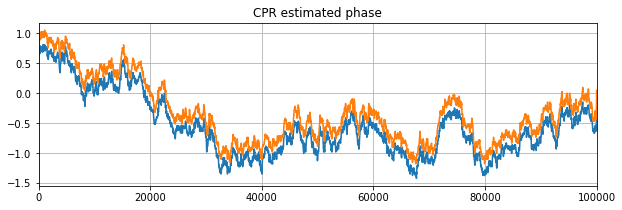

In [14]:
paramCPR = parameters()
paramCPR.alg = 'bps'
paramCPR.M   = paramTx.M
paramCPR.N   = 75
paramCPR.B   = 64
paramCPR.pilotInd = np.arange(0, len(y_EQ), 20) 

y_CPR, θ = cpr(y_EQ, symbTx=d, paramCPR=paramCPR)

y_CPR = pnorm(y_CPR)

plt.figure(figsize=(10, 3))
plt.title('CPR estimated phase')
plt.plot(θ,'-')
plt.xlim(0, len(θ))
plt.grid();

discard = 5000

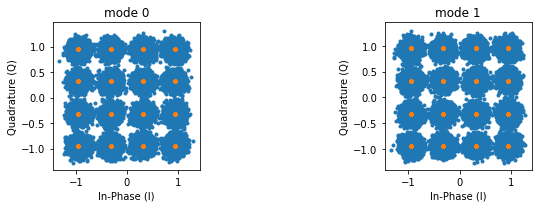

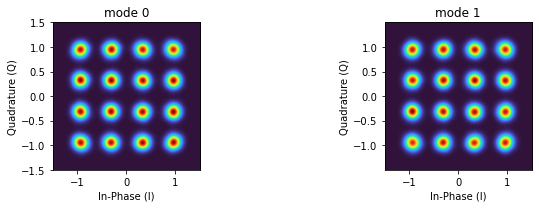

In [15]:
#plot constellations after CPR
pconst([y_CPR[discard:-discard,:],d[discard:-discard,:]], pType='fast')
pconst(y_CPR[discard:-discard,:]);

### Evaluate transmission metrics

In [16]:
# correct (possible) phase ambiguity
for k in range(y_CPR.shape[1]):
    rot = np.mean(d[:,k]/y_CPR[:,k])
    y_CPR[:,k] = rot*y_CPR[:,k]

y_CPR = pnorm(y_CPR)


ind = np.arange(discard, d.shape[0]-discard)
BER, SER, SNR = fastBERcalc(y_CPR[ind,:], d[ind,:], paramTx.M, 'qam')
GMI, NGMI = monteCarloGMI(y_CPR[ind,:], d[ind,:], paramTx.M, 'qam')
MI       = monteCarloMI(y_CPR[ind,:], d[ind,:], paramTx.M, 'qam')
EVM      = calcEVM(y_CPR[ind,:], paramTx.M, 'qam', d[ind,:])

print('     pol.X     pol.Y      ')
print('SER: %.2e, %.2e'%(SER[0], SER[1]))
print('BER: %.2e, %.2e'%(BER[0], BER[1]))
print('SNR: %.2f dB, %.2f dB'%(SNR[0], SNR[1]))
print('EVM: %.2f %%, %.2f %%'%(EVM[0]*100, EVM[1]*100))
print('MI: %.2f bits, %.2f bits'%(MI[0], MI[1]))
print('GMI: %.2f bits, %.2f bits'%(GMI[0], GMI[1]))
print('NGMI: %.2f, %.2f'%(NGMI[0], NGMI[1]))

     pol.X     pol.Y      
SER: 6.78e-04, 6.00e-04
BER: 1.69e-04, 1.50e-04
SNR: 18.71 dB, 18.71 dB
EVM: 1.34 %, 1.34 %
MI: 4.00 bits, 4.00 bits
GMI: 4.00 bits, 4.00 bits
NGMI: 1.00, 1.00
